# Garmin Statistics
## Heart rate and activities data analyses

In [1]:
%load_ext nb_black

<IPython.core.display.Javascript object>

In [2]:
import os

%matplotlib inline
import geopandas as gpd
import folium
from folium import Choropleth, Circle, Marker
from folium.plugins import HeatMap, MarkerCluster
from shapely.geometry import LineString
from dotenv import load_dotenv
import mplcursors
import garminexport
from garminconnect import (
    Garmin,
    GarminConnectConnectionError,
    GarminConnectTooManyRequestsError,
    GarminConnectAuthenticationError,
)

from datetime import timedelta, datetime as dt
from toai.imports import *
from toai.inpute import NumericInputer
from scipy.stats import skew, kurtosis

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/toai/imports.py:79: UserWarning: Could not find kaggle.json. Make sure it's located in /Users/Indre/.kaggle. Or use the environment method.
  warnings.warn(str(error))


<IPython.core.display.Javascript object>

In [3]:
load_dotenv()

MY_PSW = os.getenv("MY_PSW")
MY_EMAIL = os.getenv("MY_EMAIL")

<IPython.core.display.Javascript object>

In [4]:
try:
    client = Garmin(MY_EMAIL, MY_PSW)
except (
    GarminConnectConnectionError,
    GarminConnectAuthenticationError,
    GarminConnectTooManyRequestsError,
) as err:
    print("Error occured during Garmin Connect Client init: %s" % err)
    quit()
except Exception:
    print("Unknown error occured during Garmin Connect Client init")
    quit()

<IPython.core.display.Javascript object>

## Part 1: Getting the data

Data is colllected from **Garmin API** by using *garminconnect* package. One user's data was collected. See more about *garminconnect* [here](https://pypi.org/project/garminconnect/). Heart rate observation  and activities statistcs datasets was selected for analyses.

### Heart rate datasets

- Heart rate is recorded every 2 minutes while Garmin watch is worn. If there is no signal, `NaN` values are generated.
- `NaN` values was filled in with last non missing observation.
- *garminconnect* generates a new heart rate datasets for each 24 hour starting at midnight.
- In addition to observed heart rates, some statistics as min, max and resting heart rates are provided. 
- The heart rate dataset starts by 2019-08-31 and ends by 2020-07-20. Dates without any observations are omitted from total dataset. 
- Each heart rate has unique datestamp type index. Just time part from datestamp was selected in oder to combine heart rate observations.
- For heart rate statictics dataset *min, max, resting* and *7 days resting average heart rates* were selected. 


In [5]:
d = [
    client.get_heart_rates(str(single_date.date()))
    for single_date in pd.date_range(start="2019-08-31", periods=1, freq="D")  # 400
]
key1 = (
    "calendarDate",
    "maxHeartRate",
    "minHeartRate",
    "restingHeartRate",
    "lastSevenDaysAvgRestingHeartRate",
)
df_2 = pd.DataFrame(d)
df_3 = df_2.loc[:, key1]
df_3 = df_3.set_index("calendarDate")
df_3.head()

,maxHeartRate,minHeartRate,restingHeartRate,lastSevenDaysAvgRestingHeartRate
calendarDate,,,,
2019-08-31,170,46,62,63


<IPython.core.display.Javascript object>

In [6]:
heart_rate = pd.DataFrame()

for single_date in pd.date_range(start="2019-08-31", periods=400, freq="D"):
    try:
        d_temp = str(single_date.date())
        df_temp = pd.DataFrame.from_dict(
            client.get_heart_rates(d_temp)["heartRateValues"]
        )
        df_temp["time"] = df_temp[0].apply(
            lambda x: datetime.fromtimestamp(x / 1000).strftime("%H:%M:%S")
        )
        df_temp.set_index("time", inplace=True)
        df_temp = df_temp.drop(0, axis=1)
        df_temp.rename(columns={1: d_temp}, inplace=True)
        heart_rate = heart_rate.merge(
            df_temp, how="outer", left_index=True, right_index=True
        )
    except:
        single_date += timedelta(days=1)

heart_rate.head()

""


<IPython.core.display.Javascript object>

In [16]:
heart_rate.to_csv('heart_rate_all.csv')
df_3.to_csv('heart_rate_stats.csv')

### Activities dataset

- Activity is defined as sport activity recorded on Garmin watch. 
- Mainly running activities are in the dataset. 
- Some other types of activities are biking and open water swimming.
- Activity dataset has 172 variables as activity data, start/end time, type, distance, moving time, longitude, latitude etc. Some variables have missing values since part of the variables are valid just for particular activity type (like max power for biking).

In [ ]:
pd.DataFrame(client.get_activities(1, 400)).to_csv('activity_test.csv')

## Part 2: Graphical data analyses

Datasets prapation for analyses

In [7]:
heart_rate_df = pd.read_csv("heart_rate_all.csv")
heart_rate_df = (
    heart_rate_df.drop_duplicates(subset="time", keep="first")
    .set_index("time")
    .fillna(method="bfill", axis=1)
)
heart_rate_df.head()

,2019-08-31,2019-09-01,2019-09-02,2019-09-03,2019-09-04,2019-09-05,2019-09-06,2019-09-07,2019-09-08,2019-09-09,...,2020-07-11,2020-07-12,2020-07-13,2020-07-14,2020-07-15,2020-07-16,2020-07-17,2020-07-18,2020-07-19,2020-07-20
time,,,,,,,,,,,,,,,,,,,,,
00:00:00,75.0,71.0,71.0,71.0,62.0,56.0,56.0,56.0,99.0,55.0,...,72.0,72.0,58.0,68.0,67.0,72.0,96.0,53.0,77.0,NaN
00:02:00,70.0,71.0,77.0,77.0,62.0,58.0,55.0,58.0,96.0,55.0,...,72.0,72.0,58.0,67.0,65.0,72.0,96.0,52.0,78.0,NaN
00:04:00,72.0,70.0,66.0,66.0,62.0,58.0,55.0,61.0,88.0,56.0,...,71.0,71.0,58.0,66.0,67.0,74.0,82.0,60.0,77.0,NaN
00:06:00,80.0,72.0,60.0,60.0,58.0,57.0,56.0,59.0,78.0,56.0,...,73.0,73.0,58.0,63.0,62.0,79.0,83.0,60.0,78.0,NaN
00:08:00,73.0,97.0,54.0,54.0,55.0,57.0,56.0,59.0,69.0,56.0,...,72.0,72.0,57.0,64.0,64.0,69.0,101.0,64.0,79.0,NaN


<IPython.core.display.Javascript object>

In [8]:
activities_path = "activity_test.csv"
activities_df = pd.read_csv(
    activities_path,
    parse_dates=["startTimeLocal", "startTimeGMT"],
    index_col="Unnamed: 0",
)
activities_df.dropna(subset=["startLongitude", "startLatitude"], inplace=True)

activities_df.head()

,activityId,activityName,description,startTimeLocal,startTimeGMT,activityType,eventType,comments,parentId,distance,...,splitSummaries,hasSplits,elevationCorrected,atpActivity,purposeful,favorite,pr,autoCalcCalories,parent,decoDive
0,5163882089,Vilnius Running,NaN,2020-06-29 20:04:13,2020-06-29 17:04:13,"{'typeId': 1, 'typeKey': 'running', 'parentTyp...","{'typeId': 9, 'typeKey': 'uncategorized', 'sor...",NaN,NaN,5724.700195,...,[],False,False,False,False,False,False,False,False,NaN
1,5151705793,Pastrevys Running,NaN,2020-06-27 11:37:17,2020-06-27 08:37:17,"{'typeId': 1, 'typeKey': 'running', 'parentTyp...","{'typeId': 9, 'typeKey': 'uncategorized', 'sor...",NaN,NaN,10063.629883,...,[],False,False,False,False,False,False,False,False,NaN
2,5148742644,Elektrenai Open Water Swimming,NaN,2020-06-26 19:52:44,2020-06-26 16:52:44,"{'typeId': 28, 'typeKey': 'open_water_swimming...","{'typeId': 9, 'typeKey': 'uncategorized', 'sor...",NaN,NaN,31.990000,...,[],False,False,False,False,False,False,False,False,NaN
3,5148054776,Vilnius Cycling,NaN,2020-06-26 16:39:53,2020-06-26 13:39:53,"{'typeId': 2, 'typeKey': 'cycling', 'parentTyp...","{'typeId': 9, 'typeKey': 'uncategorized', 'sor...",NaN,NaN,7262.879883,...,[],False,False,False,False,False,False,False,False,NaN
4,5148054686,Vilnius Running,NaN,2020-06-26 16:04:47,2020-06-26 13:04:47,"{'typeId': 1, 'typeKey': 'running', 'parentTyp...","{'typeId': 9, 'typeKey': 'uncategorized', 'sor...",NaN,NaN,5137.410156,...,[],False,False,False,False,False,False,False,False,NaN


<IPython.core.display.Javascript object>

## Active and non-active days dataset
Active days are days, when sport activity is recorded, and the rest days are non-active.

In [9]:
active_days = activities_df["startTimeLocal"].dt.date.astype("str")
active_heart_rate = heart_rate_df.loc[:, heart_rate_df.columns.isin(active_days)]
active_heart_rate.head()

,2019-08-31,2019-09-01,2019-09-04,2019-09-08,2019-09-10,2019-09-11,2019-09-12,2019-09-16,2019-09-19,2019-09-21,...,2020-06-12,2020-06-14,2020-06-20,2020-06-21,2020-06-22,2020-06-23,2020-06-24,2020-06-26,2020-06-27,2020-06-29
time,,,,,,,,,,,,,,,,,,,,,
00:00:00,75.0,71.0,62.0,99.0,66.0,66.0,76.0,64.0,64.0,91.0,...,58.0,69.0,87.0,87.0,60.0,51.0,58.0,69.0,64.0,57.0
00:02:00,70.0,71.0,62.0,96.0,71.0,71.0,76.0,65.0,64.0,95.0,...,58.0,65.0,94.0,94.0,60.0,54.0,57.0,61.0,65.0,56.0
00:04:00,72.0,70.0,62.0,88.0,61.0,61.0,77.0,64.0,64.0,96.0,...,58.0,77.0,114.0,114.0,60.0,51.0,56.0,64.0,61.0,57.0
00:06:00,80.0,72.0,58.0,78.0,61.0,61.0,77.0,66.0,66.0,92.0,...,60.0,90.0,112.0,112.0,60.0,50.0,58.0,70.0,63.0,57.0
00:08:00,73.0,97.0,55.0,69.0,62.0,62.0,79.0,66.0,65.0,69.0,...,62.0,75.0,94.0,94.0,61.0,53.0,58.0,61.0,59.0,58.0


<IPython.core.display.Javascript object>

In [11]:
non_active_days = heart_rate_df.columns.difference(active_heart_rate.columns)
non_active_heart_rate = heart_rate_df.loc[
    :, heart_rate_df.columns.isin(non_active_days)
]
non_active_heart_rate.head()

,2019-09-02,2019-09-03,2019-09-05,2019-09-06,2019-09-07,2019-09-09,2019-09-13,2019-09-14,2019-09-15,2019-09-17,...,2020-07-11,2020-07-12,2020-07-13,2020-07-14,2020-07-15,2020-07-16,2020-07-17,2020-07-18,2020-07-19,2020-07-20
time,,,,,,,,,,,,,,,,,,,,,
00:00:00,71.0,71.0,56.0,56.0,56.0,55.0,76.0,66.0,65.0,64.0,...,72.0,72.0,58.0,68.0,67.0,72.0,96.0,53.0,77.0,NaN
00:02:00,77.0,77.0,58.0,55.0,58.0,55.0,76.0,66.0,65.0,64.0,...,72.0,72.0,58.0,67.0,65.0,72.0,96.0,52.0,78.0,NaN
00:04:00,66.0,66.0,58.0,55.0,61.0,56.0,77.0,57.0,65.0,64.0,...,71.0,71.0,58.0,66.0,67.0,74.0,82.0,60.0,77.0,NaN
00:06:00,60.0,60.0,57.0,56.0,59.0,56.0,77.0,59.0,65.0,66.0,...,73.0,73.0,58.0,63.0,62.0,79.0,83.0,60.0,78.0,NaN
00:08:00,54.0,54.0,57.0,56.0,59.0,56.0,79.0,64.0,65.0,65.0,...,72.0,72.0,57.0,64.0,64.0,69.0,101.0,64.0,79.0,NaN


<IPython.core.display.Javascript object>

In [12]:
len(non_active_days)

208

<IPython.core.display.Javascript object>

## Histograms

Heart rate distribution comparision during active and non-active days.

<Figure size 576x396 with 0 Axes>

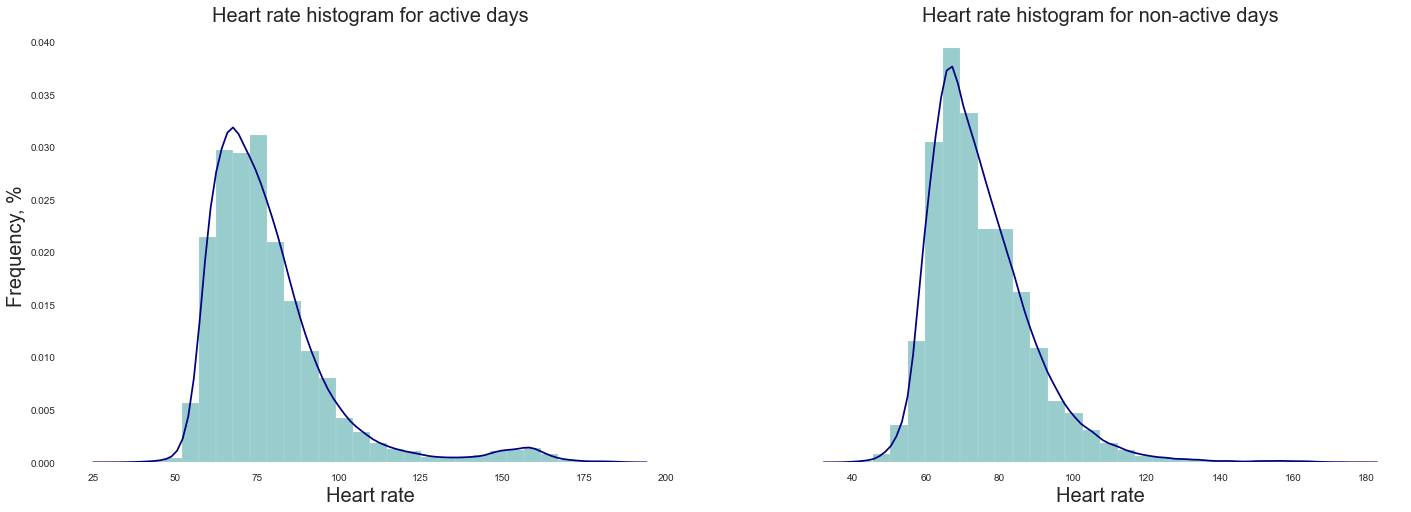

<IPython.core.display.Javascript object>

In [13]:
plt.figure()

fig, axis = plt.subplots(1, 2, figsize=(24, 8), sharey=True, frameon=False)
sns.despine(left=True)
axis[0].set_title("Heart rate histogram for active days", fontsize=20)
axis[1].set_title("Heart rate histogram for non-active days", fontsize=20)
axis[0].set_xlabel("Heart rate", fontsize=20)
axis[1].set_xlabel("Heart rate", fontsize=20)
axis[0].set_ylabel("Frequency, %", fontsize=20)

sns.distplot(
    active_heart_rate,
    hist_kws={"color": "Teal"},
    kde_kws={"color": "Navy"},
    ax=axis[0],
    bins=30,
)
sns.distplot(
    non_active_heart_rate,
    hist_kws={"color": "Teal"},
    kde_kws={"color": "Navy"},
    ax=axis[1],
    bins=30,
)

plt.tight_layout

plt.show()

- Heart rate (HR) histograms contain 24 hours heart rate observations. Active days HR dataset has 134 days, non-active days HR dataset has 208 days of observation.

- The most frequent HR interval for active days is between 73 and 78 bmp, the second frequent - between 62 and 68 bmp. Two most frequent histograms columns are not beside each other (as you would expect that in the normal distribution case) and the histogram has a spike on it's right side. 

- The most frequent HR interval for non-active days is between 64 and 69 bmp, the second frequent - between 69 and 74 bmp. Non-active days has lower the most frequent HR values than actives days and this indicates that **bmp remains higher for some time after activity**.

- Both distributions do not look like normal distribution since they are asimetrical and have fat tail on the right side. This indicates that there is more higher HR bmp values than the average. This result is expected for HR bmp histogram because bpm cannot fall to zero. The average HR bpm for active days is **78**, for non-active days - **74**. The minimum HR bmp value is **31**, the maximum -  **188** (achieved during Vilniaus maratonas race). So asymmetry of distribution is rational and HR bmp can fall down by 60 % and can jump up to 240 % from the average.

- Asymmetry of active days HR are stronger than non-active since higher HR bmp values are common during activity. Active days HR histogram looks like a multiple distribution - one for activity time and the other for the rest time. 


<Figure size 576x396 with 0 Axes>

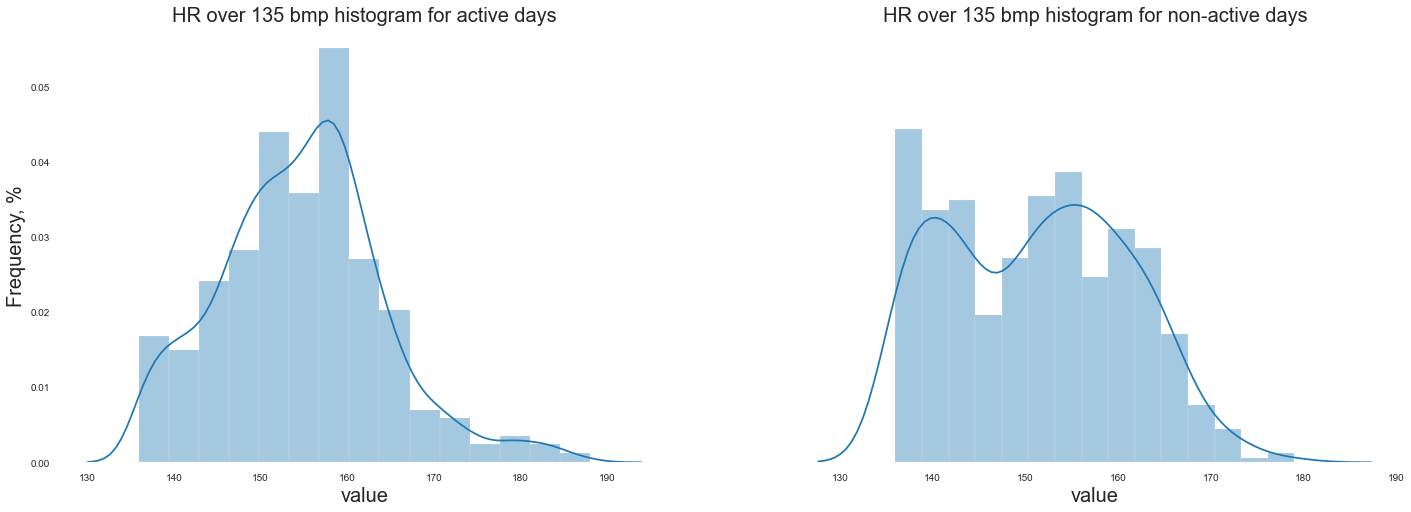

<IPython.core.display.Javascript object>

In [14]:
plt.figure()

fig, axis = plt.subplots(1, 2, figsize=(24, 8), sharey=True, frameon=False)
sns.despine(left=True)
axis[0].set_title("HR over 135 bmp histogram for active days", fontsize=20)
axis[1].set_title("HR over 135 bmp histogram for non-active days", fontsize=20)
axis[0].set_ylabel("Frequency, %", fontsize=20)
axis[0].set_xlabel("Heart rate", fontsize=20)
axis[1].set_xlabel("Heart rate", fontsize=20)

hr_max_active = pd.melt(active_heart_rate)
hr_max_active = hr_max_active[hr_max_active["value"] > 135]
plot1 = sns.distplot(hr_max_active["value"], ax=axis[0], bins=15)

hr_max_non_active = pd.melt(non_active_heart_rate)
hr_max_non_active = hr_max_non_active[hr_max_non_active["value"] > 135]
sns.distplot(hr_max_non_active["value"], ax=axis[1], bins=15)

mplcursors.cursor(hover=True)

plt.tight_layout
plt.show()

- Even non-active days have some high HR bmp observations. This can be explained that not all sport activities are recorded by a user. Automatically catched activities do not have activities statistics, so are classified as non-active.
- Sport activities that do not require GPS are not recorded by user either.
- Active and non-active days HR's distributions looks differently: first one is similar to a bell shape, second one - to a fat tail of a distribution. 

In [16]:
pd.set_option("max_columns", None)
pd.DataFrame(np.histogram(active_heart_rate, bins=30))

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30
0,5.0,17.000000,55.000000,199.0,2483.000000,9377.000000,12965.0,12878.000000,13617.000000,9166.0,6705.000000,4632.000000,3499.0,1856.000000,1258.000000,783.0,547.000000,452.000000,239.0,189.000000,202.000000,300.0,463.000000,510.000000,588.0,333.000000,96.000000,42.0,40.000000,24.000000,NaN
1,31.0,36.233333,41.466667,46.7,51.933333,57.166667,62.4,67.633333,72.866667,78.1,83.333333,88.566667,93.8,99.033333,104.266667,109.5,114.733333,119.966667,125.2,130.433333,135.666667,140.9,146.133333,151.366667,156.6,161.833333,167.066667,172.3,177.533333,182.766667,188.0


<IPython.core.display.Javascript object>

In [17]:
# pd.set_option("max_columns", None)
pd.DataFrame(np.histogram(non_active_heart_rate, bins=30, range=(35, 180)))

/Users/Indre/Library/Python/3.7/lib/python/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/Indre/Library/Python/3.7/lib/python/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30
0,11.0,77.000000,416.000000,1851.0,9104.000000,16597.000000,27763.0,24611.000000,20249.000000,15804.0,11553.000000,6460.000000,5406.0,3363.000000,2201.000000,1318.0,846.000000,414.000000,351.0,243.000000,172.000000,98.0,78.000000,51.000000,94.0,95.000000,73.000000,27.0,8.000000,2.000000,NaN
1,35.0,39.833333,44.666667,49.5,54.333333,59.166667,64.0,68.833333,73.666667,78.5,83.333333,88.166667,93.0,97.833333,102.666667,107.5,112.333333,117.166667,122.0,126.833333,131.666667,136.5,141.333333,146.166667,151.0,155.833333,160.666667,165.5,170.333333,175.166667,180.0


<IPython.core.display.Javascript object>

In [18]:
sk = skew(pd.melt(active_heart_rate)["value"])
kur = kurtosis(pd.melt(active_heart_rate)["value"])
m = pd.melt(active_heart_rate)["value"].mean()
hr_max = pd.melt(active_heart_rate)["value"].max()
hr_min = pd.melt(active_heart_rate)["value"].min()
print(
    "skewness = ",
    sk,
    ", kurtosis = ",
    kur,
    ", mean = ",
    m,
    ", max = ",
    hr_max,
    ", min = ",
    hr_min,
)

skewness =  2.1491809403105337 , kurtosis =  6.075911821877197 , mean =  78.42866379310345 , max =  188.0 , min =  31.0


<IPython.core.display.Javascript object>

In [19]:
sk = skew(pd.melt(non_active_heart_rate.dropna())["value"])
kur = kurtosis(pd.melt(non_active_heart_rate.dropna())["value"])
m = pd.melt(non_active_heart_rate)["value"].mean()
hr_max = pd.melt(non_active_heart_rate)["value"].max()
hr_min = pd.melt(non_active_heart_rate)["value"].min()
print(
    "skewness = ",
    sk,
    ", kurtosis = ",
    kur,
    ", mean = ",
    m,
    ", max = ",
    hr_max,
    ", min = ",
    hr_min,
)

skewness =  1.3867100239542534 , kurtosis =  4.155483225112308 , mean =  74.9098141104623 , max =  179.0 , min =  36.0


<IPython.core.display.Javascript object>

In [20]:
HR_stats_df = pd.read_csv("heart_rate_stats.csv")

<IPython.core.display.Javascript object>

In [21]:
active_heart_rate[active_heart_rate["2019-09-08"] == 188].index.values

array(['14:48:00', '14:50:00'], dtype=object)

<IPython.core.display.Javascript object>

## Plots

Min and max heart rates comparision

In [22]:
active_stats = active_heart_rate.describe()
non_active_stats = non_active_heart_rate.describe()
active_stats_t = active_stats.T
non_active_stats_t = non_active_stats.T

<IPython.core.display.Javascript object>

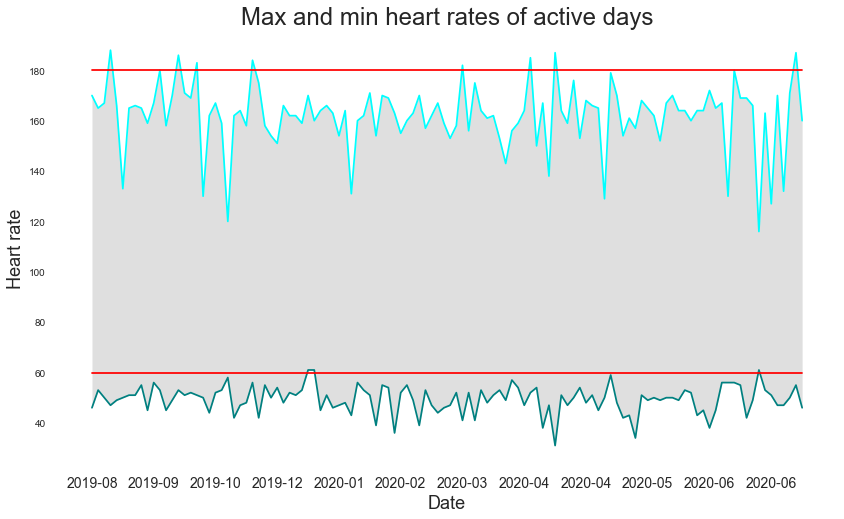

<IPython.core.display.Javascript object>

In [24]:
# labels to x axis
dates = pd.DataFrame(list(active_stats.columns))
dates = dates.iloc[:, 0].apply(lambda x: dt.strptime(x, "%Y-%m-%d"))

plt.figure(figsize=(14, 8))
plt.title("Max and min heart rates of active days", fontsize=24)
plt.style.use("seaborn-pastel")

sns.lineplot(data=active_stats.loc["min"], color="Teal", ci="sh", markers="-o")
sns.lineplot(data=active_stats.loc["max"], color="Cyan")
sns.lineplot(data=pd.Series([60] * len(active_stats.loc["min"])), color="Red")
sns.lineplot(data=pd.Series([180] * len(active_stats.loc["min"])), color="Red")

plt.gca().fill_between(
    range(len(active_stats.loc["min"])),
    active_stats.loc["min"],
    active_stats.loc["max"],
    facecolor="grey",
    alpha=0.25,
)
plt.legend = ["Min", "Max"]
plt.xlabel("Date", fontsize=18)
plt.ylabel("Heart rate", fontsize=18)
locs, labels = plt.xticks()
plt.xticks(
    list(active_stats.columns)[0::10], dates.dt.to_period("M")[0::10], fontsize=14
)

plt.show()

- Line at 180 HR bmp is wanted max limit of HR. Higher values might indicate overtraining.
- Line at 60 HR bmp indicates max resting HR. Higher resting HR might indicate overtraining as well.
- Max HR is more volatile that min HR, this indicates that activities were different in intensity and heart can calm down after activities.


## Boxplot

Min and max heart rates comparison by using boxplots

<Figure size 576x396 with 0 Axes>

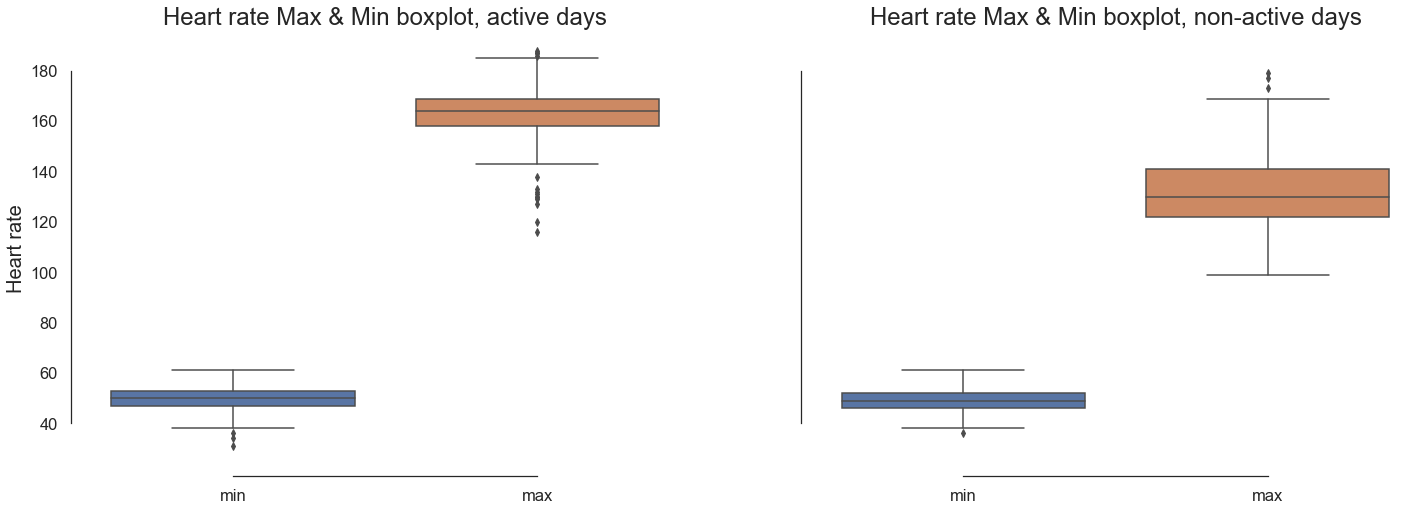

<IPython.core.display.Javascript object>

In [29]:
plt.figure()

sns.set(font_scale=1.5)
sns.set_style("white")

fig, axis = plt.subplots(1, 2, figsize=(24, 8), sharey=True, frameon=False)
axis[0].set_title("Heart rate Max & Min boxplot, active days", fontsize=24)
axis[1].set_title("Heart rate Max & Min boxplot, non-active days", fontsize=24)

sns.boxplot(
    x="variable",
    y="value",
    data=pd.melt(active_stats_t.loc[:, ["min", "max"]]),
    ax=axis[0],
)
sns.boxplot(
    x="variable",
    y="value",
    data=pd.melt(non_active_stats_t.loc[:, ["min", "max"]]),
    ax=axis[1],
)

sns.despine(offset=10, trim=True)
axis[0].set_xlabel("")
axis[1].set_xlabel("")
axis[0].set_ylabel("Heart rate", fontsize=20)
axis[1].set_ylabel("")

plt.show()

- Boxplot confirms the insights made from the previous graph: max HR's volatile much more than min HR's and have different statistics between active and non-active days.
- Max HR's show intensity of activity.
- Min HR's show resting quality.

## Bar plot

Activities summary

In [30]:
activities_df["month"] = activities_df["startTimeLocal"].dt.month_name()
activities_df["distance"] = activities_df["distance"].div(1000)

<IPython.core.display.Javascript object>

In [31]:
activities_df = activities_df[activities_df["startTimeLocal"] > "2019-08-30"]
activities_df["startTimeLocal"].describe()

count                     129
unique                    129
top       2020-04-23 11:40:02
freq                        1
first     2019-08-31 19:23:47
last      2020-06-29 20:04:13
Name: startTimeLocal, dtype: object

<IPython.core.display.Javascript object>

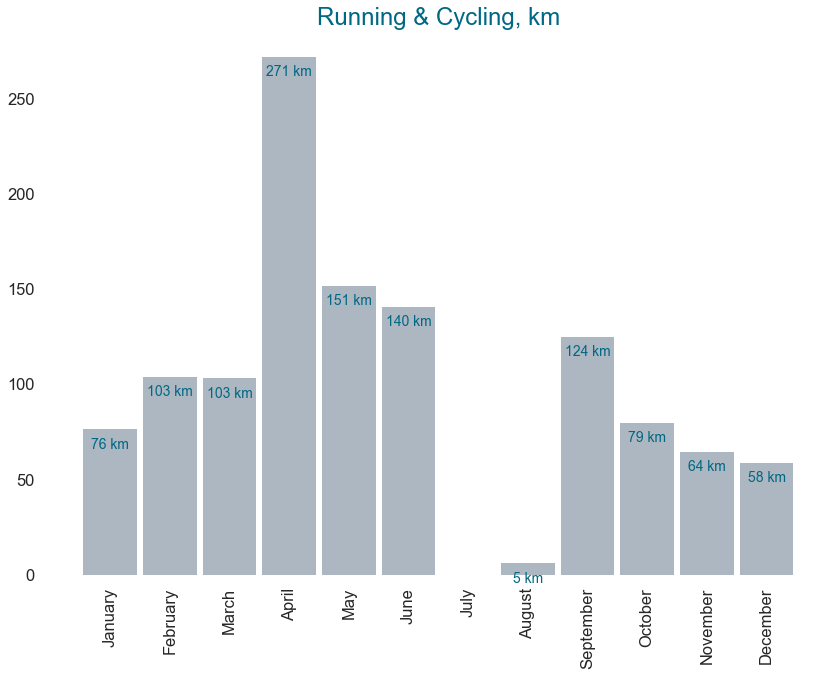

<IPython.core.display.Javascript object>

In [32]:
months = [
    "January",
    "February",
    "March",
    "April",
    "May",
    "June",
    "July",
    "August",
    "September",
    "October",
    "November",
    "December",
]
plt.figure(figsize=(14, 10))
activities_df["month"] = pd.Categorical(
    activities_df["month"], categories=months, ordered=True
)

bars = plt.bar(
    months,
    activities_df.groupby("month")["distance"].sum(),
    alpha=0.6,
    align="center",
    width=0.9,
    linewidth=0,
    color="lightslategrey",
)
plt.title("Running & Cycling, km", fontsize=24, color="#006884")
plt.xticks(rotation=90)
for spine in plt.gca().spines.values():
    spine.set_visible(False)

list_1 = bars[:6] + bars[7:]
for bar in list_1:
    plt.gca().text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height() - 10,
        str(int(bar.get_height())) + " km",
        ha="center",
        color="#006884",
        fontsize=14,
    )
plt.show()

- First activity recorded on 31'st of August, 2019.
- Last activity recorded on 29'th of June, 2020.
- Q4 is usually low season.
- Peak in April show quarantine impact. 
- Key take away - running season is all year round in Lithuania :).

## Geo graphs

In [35]:
activities = gpd.GeoDataFrame(
    activities_df,
    geometry=gpd.points_from_xy(
        activities_df["startLongitude"], activities_df["startLatitude"]
    ),
)

<IPython.core.display.Javascript object>

### Start place and quatity of sport activities 

In [34]:
import math

locations_map = folium.Map(
    location=[54.6872, 25.2797], tiles="cartodbpositron", zoom_start=13
)

# Add points to the map
mc = MarkerCluster()
for idx, row in activities_df.iterrows():
    if not math.isnan(row["startLongitude"]) and not math.isnan(row["startLatitude"]):
        mc.add_child(Marker([row["startLatitude"], row["startLongitude"]]))
locations_map.add_child(mc)

locations_map

<IPython.core.display.Javascript object>

- Popular running locations - near home and near work.
- Activities dutring holidays and work travel too.

### Heatmap of sport activities

In [33]:
sport_heatmap = folium.Map(
    location=[54.6872, 25.2797], tiles="cartodbpositron", zoom_start=8
)
HeatMap(data=activities_df[["startLatitude", "startLongitude"]], radius=10).add_to(
    sport_heatmap
)

sport_heatmap

<IPython.core.display.Javascript object>